<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Sebastián Ojeda G.


### **Link de repositorio de GitHub:** `https://github.com/sebajedi23/MDS7202`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

#0. Imports

In [1]:
!pip install xgboost

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.9 MB/s eta 0:00:00


In [4]:
#Importamos las librerías a usar

#Sci-kit learn
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, StandardScaler

#Otros
from alibi.explainers import AnchorTabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from tabulate import tabulate
import warnings
from xgboost import XGBClassifier, plot_importance
import warnings

In [5]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/Colab Notebooks/Laboratorio de programación científica para ciencia de datos/Lab 10/'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


In [6]:
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [7]:
df = pd.read_csv(path + 'diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

In [8]:
#Revisamos los valores únicos de cada columna
for col in df.columns:
    uniq = len(df[col].unique())
    print(f'Valores únicos en {col}: {uniq}')

Valores únicos en Age: 13
Valores únicos en Sex: 2
Valores únicos en HighChol: 2
Valores únicos en CholCheck: 2
Valores únicos en BMI: 80
Valores únicos en Smoker: 2
Valores únicos en HeartDiseaseorAttack: 2
Valores únicos en PhysActivity: 2
Valores únicos en Fruits: 2
Valores únicos en Veggies: 2
Valores únicos en HvyAlcoholConsump: 2
Valores únicos en GenHlth: 5
Valores únicos en MentHlth: 31
Valores únicos en PhysHlth: 31
Valores únicos en DiffWalk: 2
Valores únicos en Stroke: 2
Valores únicos en HighBP: 2
Valores únicos en Diabetes: 2


In [9]:
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.062171,0.563458,0.500000
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.241468,0.495960,0.500004
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


A partir de lo anterior notamos que hay varias columnas que tienen 2 valores únicos correspondientes a 0 y 1, por lo que estas son de caracter categórico.

Luego tenemos variables como GenHlth, MentHlth y PhysHlth que tienen más valores pero van de 0 a 5 o de 0 a 30, siempre en números discretos, lo que deja entrever que son de carácter ordinal, clasificando las variables en diferentes niveles.

Finalmente, existen variables como la edad o el IMC (BMI en este caso) que sabemos que son numéricas por lo que se definirán como tal.

In [10]:
#Clasificamos las variables de acuerdo a su tipo
categoric = ['Sex', 'HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack',
             'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
             'DiffWalk', 'Stroke', 'HighBP',]
ordinal = ['GenHlth', 'MentHlth', 'PhysHlth']
numeric = ['Age', 'BMI']

In [11]:
#Dividimos los datos usando Diabetes como target
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

#Dividimos en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Definimos el ColumnTransformer con distinción por tipo de variable
preprocessor = ColumnTransformer(
                                  [
                                  ('One Hot', OneHotEncoder(sparse=False, handle_unknown="ignore", drop='if_binary'), categoric),
                                  ('Ordinal', OrdinalEncoder(), ordinal),
                                  ('Scaler', MinMaxScaler(), numeric)
                                  ],
                                    remainder='passthrough'
                                  )

#Creamos el pipeline con pre-procesamiento y regresión
pipeline = Pipeline(steps=[
                            ("preprocessing", preprocessor),
                            ("model", XGBClassifier(random_state=42))
                            ])

#Entrenamos el pipeline con los datos de train
pipeline.fit(X_train, y_train)

#Predecimos sobre los datos de test
y_pred = pipeline.predict(X_test)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



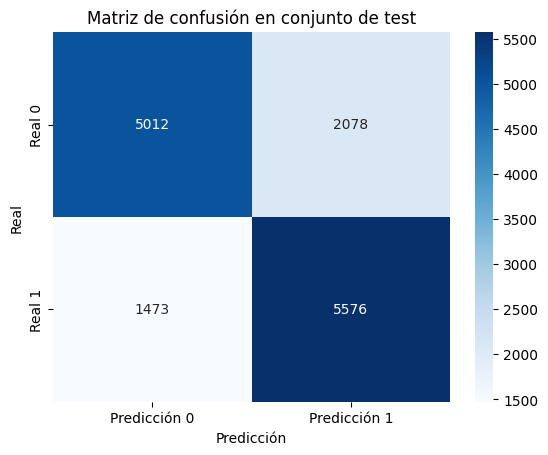

In [12]:
#Mostramos los resultados relevantes
print(classification_report(y_test, y_pred))

#Obtenemos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

#Mostramos la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicción 0', 'Predicción 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.title('Matriz de confusión en conjunto de test')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

¿Es acaso un buen predictor de diabetes?

**Respuesta:**
```
A grandes rasgos podría decirse que el modelo es un buen predictor de diabetes, ya que logra clasificar correctamente la mayoría de
los datos, sin embargo es importante considerar los riesgos que implica una mala clasificación, tanto al diagnosticar como
diabética a una persona que no padece la enfermedad, y más aún, como no diabética a una persona que sí la padece.
Esto último es muy relevante a la hora de juzgar los resultados, pues puede ser preferible diagnosticar mal a los no diabéticos con
tal de no dejar a los reales diabéticos sin diagnóstico y poner en riesgo sus vidas.
```
¿Qué buscan explicar las métricas utilizadas?

**Respuesta:**
```
A continuación se entrega una descripción de cada métrica, cabe mencionar que la clase 0 corresponde a diabetes negativo y la clase
1 a diabetes positivo.

Precision: Es la tasa de verdaderos positivos sobre el total de predicciones positivas del modelo, es decir, la proporción de
predicciones positivas que efectivamente son positivas.
Con esto tenemos que el 77% de los diagnósticos de no diabetes son correctos, lo que deja un 23% de pacientes con diabetes no
diagnosticada. Por otro lado, se tien un 73% de diagnósticos de diabetes correctos, lo que deja un 27% de pacientes diagnosticados
con diabetes y que no padecen la enfermedad.

Recall: Es la tasa de predicciones positivas entre todos los casos que efectivamente son positivos.
A partir de esto se tiene que de todos los diagnósticos de no diabetes, el modelo identificó correctamente al 71% de ellos,
dejando al 29% restante identificado como diabetes, mientras que el 79% de los casos de diabetes fueron detectados correctamente,
dejando no diagnosticados a un 21% que efectivamente padecen
diabetes.

F1-score: Corresponde a la media armónica de precision y recall, combinándolos ambos en una sola métrica.
El F1-score es del 74% para la clase no diabetes, mientras que para la clase diabetes es del 76%.

Accuracy: Es la tasa de predicciones correctas en general.
El modelo present una precisión del 75%, lo que significa que el 75% de las predicciones totales fueron correctamente clasificadas.
```
¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?

**Respuesta:**
```
No, ya que estas métricas únicamente nos dan información sobre los resultados y no sobre cómo se llegó a ellos o la contribución de
cada feature en el modelo.
```

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

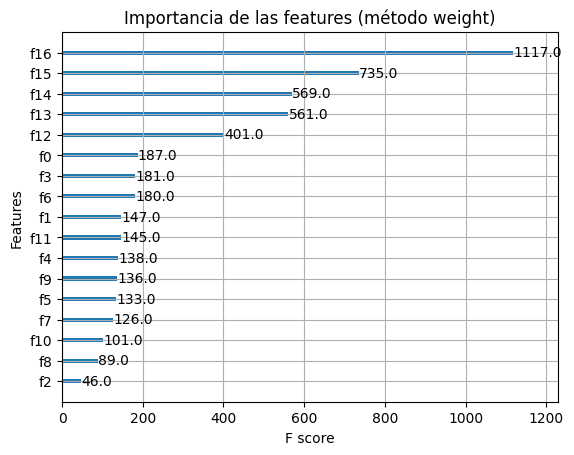

In [13]:
#Obtenemos la importancia de las features de acuerdo a weight
plot_importance(pipeline.named_steps['model'], importance_type='weight')
plt.title('Importancia de las features (método weight)')
plt.show()

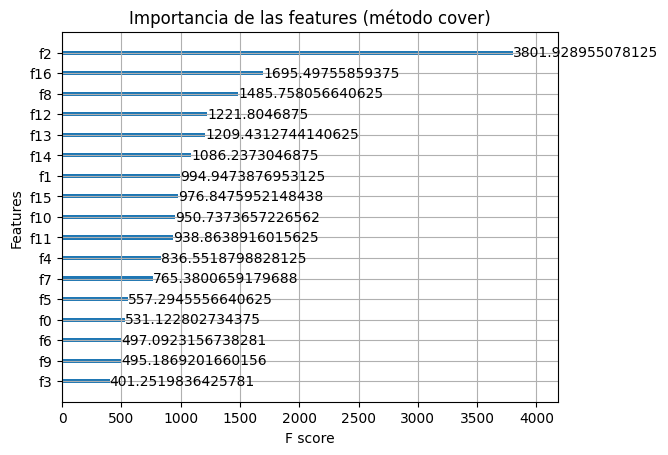

In [14]:
#Obtenemos la importancia de las features de acuerdo a cover
plot_importance(pipeline.named_steps['model'], importance_type='cover')
plt.title('Importancia de las features (método cover)')
plt.show()

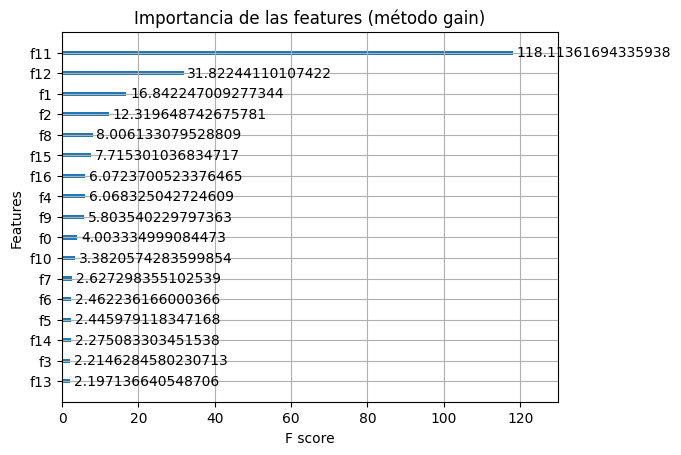

In [15]:
#Obtenemos la importancia de las features de acuerdo a gain
plot_importance(pipeline.named_steps['model'], importance_type='gain')
plt.title('Importancia de las features (método gain)')
plt.show()

In [16]:
#Obtener¡mos el nombre de cada feature con su número y una f antepuesta
features_dict = {f'f{i}': column for i, column in enumerate(X_train.columns)}

#Imprimimos los nombres de las features
print("Nombre de las features en los gráficos:")
for key, value in features_dict.items():
    print(f"{key}: {value}")

Nombre de las features en los gráficos:
f0: Age
f1: Sex
f2: HighChol
f3: CholCheck
f4: BMI
f5: Smoker
f6: HeartDiseaseorAttack
f7: PhysActivity
f8: Fruits
f9: Veggies
f10: HvyAlcoholConsump
f11: GenHlth
f12: MentHlth
f13: PhysHlth
f14: DiffWalk
f15: Stroke
f16: HighBP


¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados.

**Respuesta:**
```
Los resultados obtenidos al usar los tres distintos métodos no son del todo compatibles entre sí, esto se debe a que cada uno de
los métodos considera distintos factores para obtener la importancia de cada feature. Mientras que weight considera la
frecuencia de aparición de la feature en los nodos de entrenamiento, cover considera la cantidad de nodos de
entrenamiento afectados por ella y gainla mejora en la precisión que se obtiene al dividir el conjunto de datos basándose en la
feature.
A partir de lo obtenido se puede ver que hay features como f12 o f16 que aparecen entre los primeros lugares de relevancia para los
tres métodos, mientras que otras como f2 y f8 están entre las menos relevantes en weight pero entre las más relevantes en los otros dos
métodos.
```

¿Las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

**Respuesta:**
```
Si bien las métricas de importancia de features entregan información valiosa sobre la importancia de las variables en el
entrenamiento, la interpretabilidad de un modelo no se limita sólo a estas métricas. Las importancias de características son útiles,
pero la interpretabilidad del modelo es algo más amplio que implica comprender de manera más concisa cómo y en qué se base el modelo
para tomar decisiones.

Es importante también mencionar que estos métodos no consideran puntos relevantes como la importancia conjunta que
tienen dos o más features en el entrenamiento, además de estar altamente sujetas a cambios dependiendo del conjunto de datos
utilizado, sin embargo estos siguen siendo útiles para tener un primer acercamiento a la relevancia de cada feature.
```

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

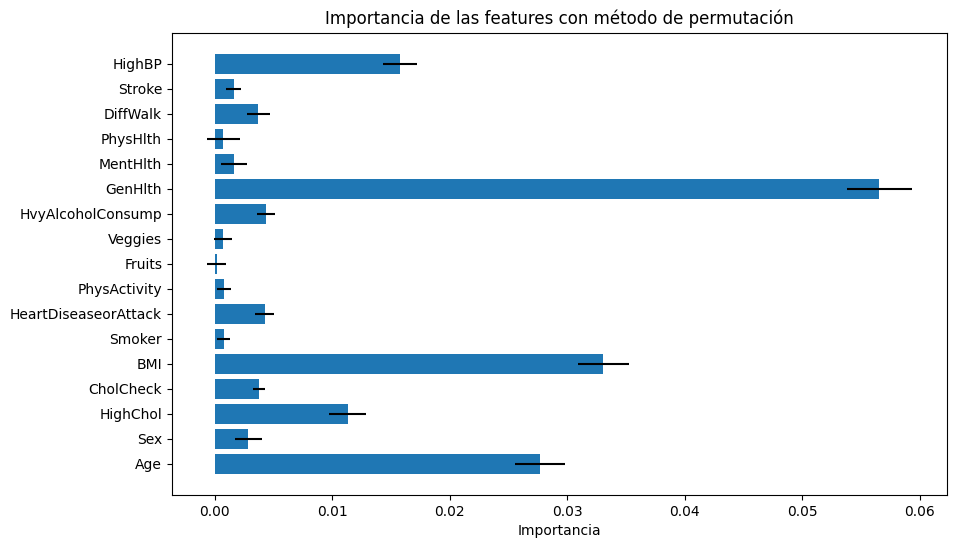

In [17]:
#Calculamos la importancia de cada feature con el método de permutación a 30 repeticiones
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

#Obtenemos las importancias promedio por feature y sus desviaciones estándar
mean_importance = perm_importance.importances_mean
std_importance = perm_importance.importances_std

#Graficamos la importancia de las features
features = X_test.columns
plt.figure(figsize=(10, 6))
plt.barh(features, mean_importance, xerr=std_importance, align='center')
plt.xlabel('Importancia')
plt.title('Importancia de las features con método de permutación')
plt.show()

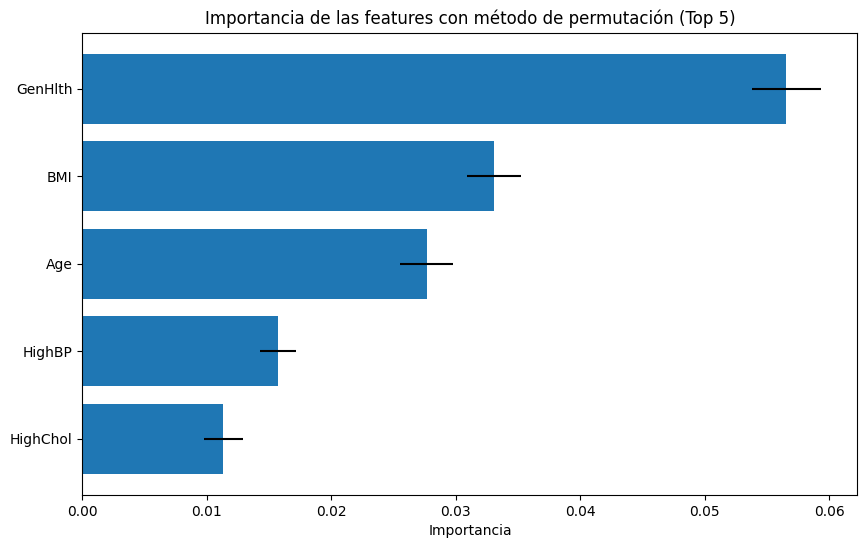

In [18]:
#Graficamos las 5 variables de mayor importancia
plt.figure(figsize=(10, 6))
plt.barh(features[np.argsort(mean_importance)[-5:]],
         mean_importance[np.argsort(mean_importance)[-5:]],
         xerr=std_importance[np.argsort(mean_importance)[-5:]],
         align='center')
plt.xlabel('Importancia')
plt.title('Importancia de las features con método de permutación (Top 5)')
plt.show()

Para que su modelo sea consistente, repita el proceso 30 veces y verifique la desviación estándar de sus resultados (¿Qué señala está?)


**Respuesta:**
```
En los gráficos anteriores, las barras azules representan a las importancias promedio de cada feature a lo largo de las 30
iteraciones, mientras que la desviación estándar se muestra en forma de una barra de error que indica cuanto se dispersan las
importancias de cada iteración respecto al promedio de importancia obtenido para la variable. A mayor tamaño de la barra de error,
mayor variabilidad entre iteraciones posee la feature, mientras que si la barra es más pequeña, su importancia es más consistente
a lo largo de las 30 repeticiones.
```
¿Cómo mide la importancia de las features su propuesta?

**Respuesta:**
```
El método propuesto (permutación) obtiene la importancia de las features introduciendo perturbaciones aleatorias con el fin de ver
cómo estas afectan al modelo y sus resultados. Así, al modificarse una feature, si esta impacta en gran medida al modelo se
considera como importante, ya que el rendimiento del mismo está sujeto al valor de dicha feature. Por otro lado si una feature
modificada no cambia en gran medida la respuesta del modelo se considerará menos relevante.
```
¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?

**Respuesta:**
```
Las 5 características más importantes obtenidas para este modelo (en orden) son las que siguen:

GenHlth (General Health): Corresponde a la salud general del paciente, tiene sentido que esta sea relevante para las
predicciones, ya que la salud general es uno de los factores que más suele influir en el desarrollo de enfermedades en general, no
sólo diabetes.

BMI (Body Mass Index): El índice de masa corporal está estrechamente relacionado con la obesidad, la que a su vez
constituye un factor de riesgo para la diabetes.
Tiene sentido la relevancia de esta feature en el modelo.

Age (Edad): Si bien la edad no es es un factor de riesgo para la diabetes tipo 1, la que puede desarrollarse a cualquier edad, la
diabetes tipo 2 guarda estrecha relación con la edad, siendo más común en personas de más edad, como los adultos mayores.
Es lógico pues, que la edad sea uno de los factores más importantes para el modelo, debida la alta relación que tiene con el
desarrollo de diabetes tipo 2, que cabe mencionar, es el tipo más común de esta enfermedad.

HighBP (High Blood Pressure): Es sabido que la presión arterial alta puede ser un síntoma es o factor de riesgo respectivo a la
diabetes, por lo que es normal que personas con la enfermedad tengan también esta condición. Por lo anterior, también tiene
sentido la presencia de esta feature en el top 5.

HighChol (High Cholesterol): El colesterol alto puede contribuir con el desarrollo de resistencia a la insulina, lo que a su vez
puede elevar los niveles de glucosa en la sangre, llevando al desarrollo de diabetes.
Lo anterior, deja en evidencia el porqué de la importancia de esta feature.
```
¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?

**Respuesta:**
```
Los resultados cambian bastante, ya que en la parte anterior se analizan tres métodos que entregan tres diferentes órdenes de
importancia para las features. Si comparamos el top 5 de cada uno de esos métodos con el top 5 del modelo actual, notamos que
GenHlth, la feature más importante para el actual modelo, aparece sólo una vez en el top 5 de los métodos anteriores,
específicamente en el primer lugar del método Gain, por otra parte, BMI, la segunda feature más importante para este método, no
aparece ninguna vez en el top 5 de alguno de los métodos anteriores. Para completar el top 5, tenemos que Age aparece una
vez en el tercer lugar del método Gain, HighBP aparece dos veces, tanto en Weight (teniendo el primer lugar) y en Cover (teniendo
el segundo lugar), y por último HighChol aparece una vez en el primer lugar del método Cover.
Con lo anterior es evidente que las conclusiones que se pueden extraer varían en gran medida para cada método analizado,
teniéndose concordancias muy leves entre métodos, esto debido a la forma en que cada uno calcula las importancias.
```
Nombre y explique 3 ventajas y 3 desventajas del método implementado.

**Respuesta:**
```
Ventajas:
El modelo es fácil de interpretar, calculando el impacto que tiene una variación aleatoria en alguna feature sobre la precisión del
modelo, estableciendo así su importancia, medida que es fácil de entender y comparar con las importancias de otras features.

Puede ser aplicado frente a cualquier modelo supervisado, por lo que se puede utilizar en una amplia selección de algoritmos de
aprendizaje, no restringiéndose a un tipo específico de modelo.

Al obtener el impacto de una variación aleatoria en una feature, el método es capaz de discernir si una característica es
irrelevante para el modelo, mostrando un nivel de importancia menor debido a que su variación no afecta en gran medida la precisión
del modelo.


Desventajas:
El método presente es más costoso computacionalmente que los anteriores, esto queda en evidencia debido a los tiempos de
ejecución inferiores a 1 segundo obtenidos con los métodos anteriores, frente a los cerca de 45 segundos que toma este
último método

El hecho de estar basado en la introducción de ruidos aleatorios hace que el método sea altamente variable, lo que se puede
solucionar con la ejecución reiterada del mismo como se hizo en este caso al repetirlo 30 veces. Estas iteraciones, si bien ayudan
a combatir la aleatoriedad de los resultados, también contribuyen y explican en parte la desventaja tratada en el punto anterior.

Al igual que los métodos anteriores, a pesar de mostrar las importancias de las features individualmente, pudiendo ver cuáles
son las más o menos importantes, este modelo tampoco toma en cuenta relaciones que podrían tener las features entre sí, pasando por
alto causalidades o interacciones entre ellas, además de poder subestimar la importancia de features que, al estar relacionadas
con otra, generan un impacto menor en el modelo.
```

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [19]:
#Silenciamos las advertencias
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

#Obtenemos el modelo clasificador del pipeline
model_xgb= pipeline.named_steps['model']

#Creamos el explainer con el clasificador
explainer = shap.TreeExplainer(model_xgb)

#Calculamos los shap values para los valores de test
shap_values = explainer.shap_values(X_test)

#Mostramos los shap values
print(shap_values)

[22:04:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[[ 0.19907439 -0.43168056  0.02782273 ...  0.01661607 -1.1009325
  -0.81213576]
 [ 0.28264233 -0.662479   -1.5374136  ...  0.08815806 -0.9935887
  -1.5009142 ]
 [ 0.28812346  0.36036736  0.02187734 ... -0.2830203  -0.14152385
   0.72802246]
 ...
 [ 0.26419824  0.7027697  -1.7642186  ...  0.22369125 -0.7606582
  -0.54877245]
 [ 0.01274119 -0.31738442  0.03057383 ... -0.161146   -0.83821034
   1.3758996 ]
 [ 0.1725879   0.39725223  0.02184614 ... -0.5326968  -0.99787766
  -1.6188208 ]]


¿Qué representa cada número en su resultado?

**Respuesta:**
```
Los shap values muestran la influencia de cada una de las features en la predicción del modelo en un caso específico, por lo que
cada número en los shap values muestra cómo una feature en específico influye en la predicción de dicho caso específico.
```
¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

**Respuesta:**
```
Que un valor sea positivo o negativo nos indica el tipo de contribución que la feature genera en la predicción.
Al tenerse un valor positivo se tiene una contribución positiva en al predicción, es decir, contribuye a un aumento en la predicción
del caso en cuestión.
Por el contrario, un valor negativo quiere decir que la presencia de la feature contribuye negativamente a la predicción, es decir,
contribuye a una disminución en el valor de la predicción.
```

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

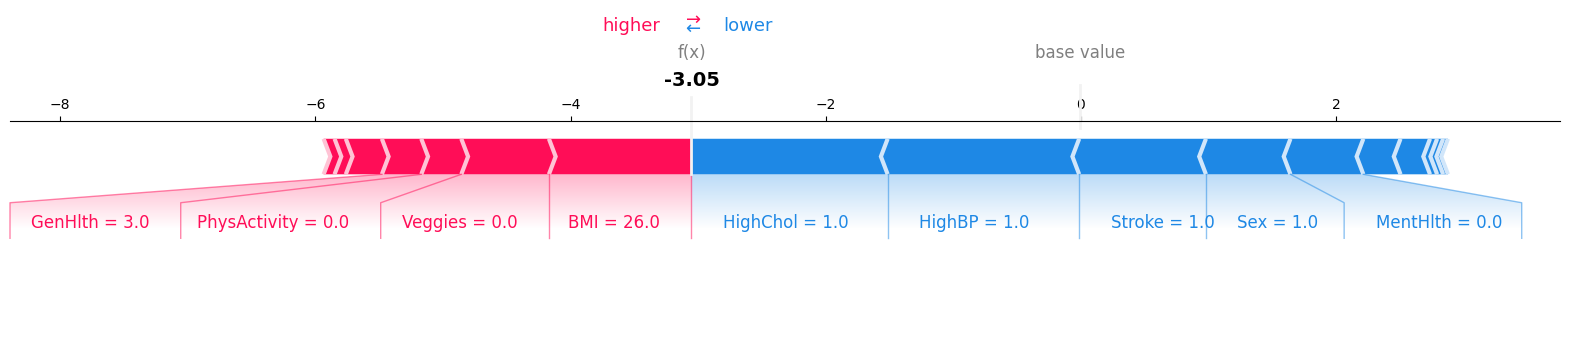

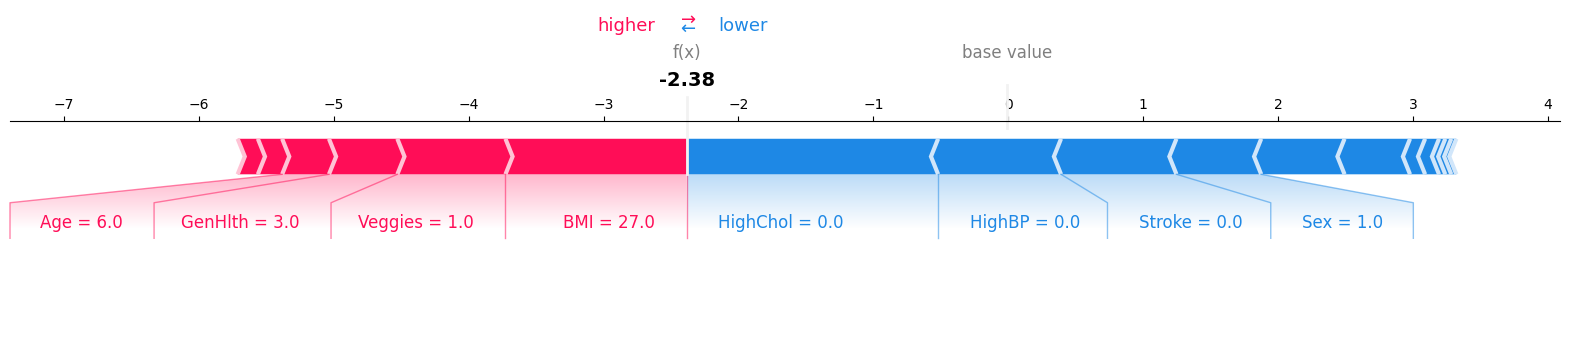

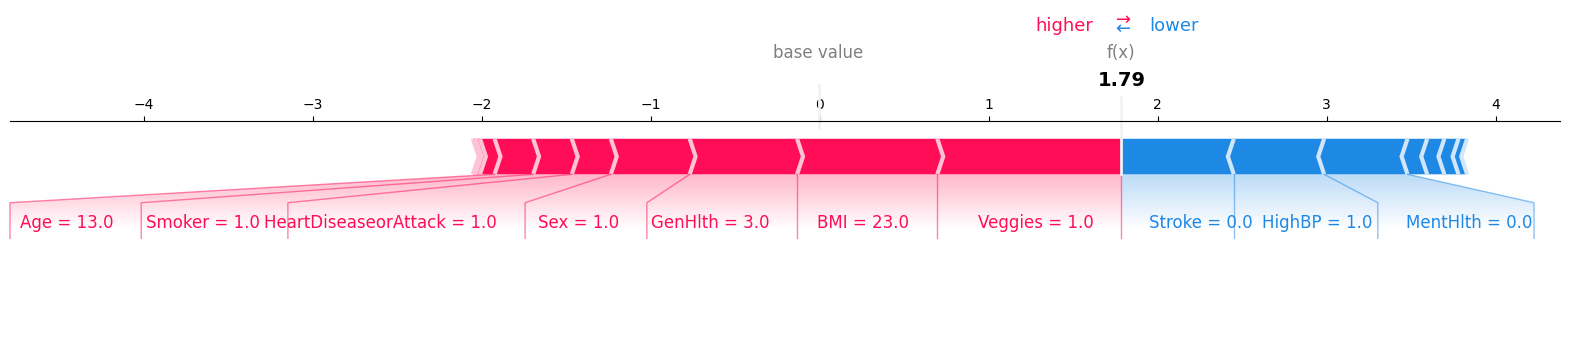

In [20]:
#Inicializamos el entorno de java script
shap.initjs()

#Guardamos los shap values en un DataFrame
shap_values_df = pd.DataFrame(shap_values, columns=df.drop('Diabetes', axis=1).columns)

#Definimos las instacias cuyos resultados se quieren analizar
instances = [1, 9, 150]

#Mostramos los resultados para cada instancia
for instance in instances:
    shap.force_plot(explainer.expected_value, shap_values[instance], df.drop('Diabetes', axis=1).iloc[instance], matplotlib=True)

¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?

**Respuesta:**
```
En los gráficos se muestran en color rojo las variables que afectan positivamente y en azul las que afectan negativamente, con esto
tenemos que variables como Stroke, HighBP, MentHlth, HighBP y HighChol pueden contribuir negativamente, mientras que Age,
PhysActivity, Veggies, BMI, GenHlth, Smoker y HeartDeseaseorAttack contribuyen positivamente, ademas, Sex puede contribuir tanto
positiva como negativamente.
```
¿Existe algún patrón común entre las instancias analizadas?

**Respuesta:**
```
No existen patrones claros en común entre las instancias analizadas, esto puede deberse a que la contribución de cada
variable depende del valor de la misma y la combinación de valores para la insatancia específica, por ejemplo, un valor de Age = 6
en una instancia puede influir de una forma, mientras que un valor de Age = 60 en otra instancia puede influir de otra.
```
¿Es posible generalizar estas conclusiones a todo el dataset?

**Respuesta:**
```
Por lo mencionado anteriormente, los shap values no son generalizables a todo el dataset, son mas bien útiles a la hora de
analizar instancias específicas y visualizar las características más influyentes para un individuo.
```

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

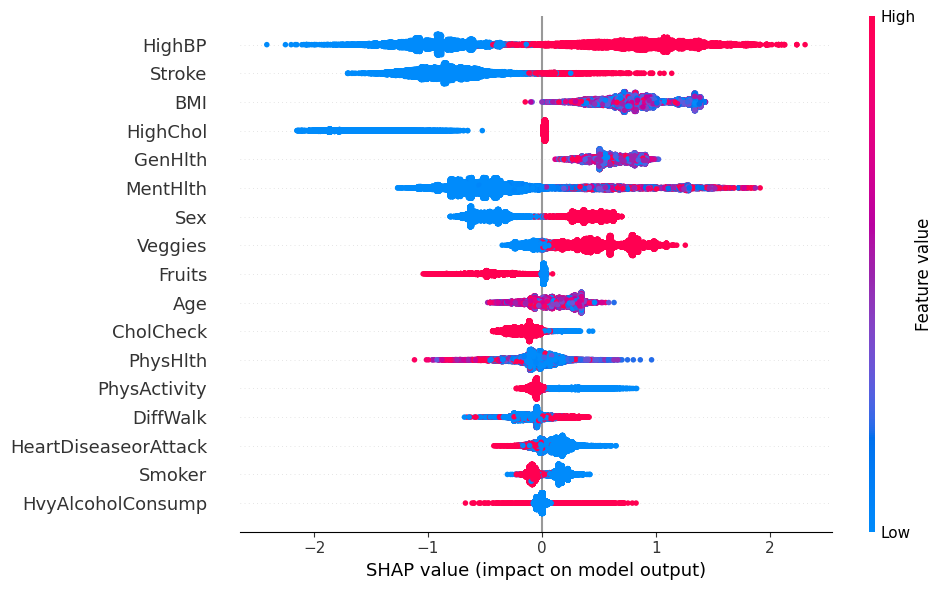

In [25]:
#Graficamos los shap values por feature
shap.summary_plot(shap_values, X_test, plot_size=(10, 6))
plt.show()

¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

**Respuesta:**
```
En este caso se observan los impactos de cada características en cada una de las instancias, por lo que a diferencia del caso
anterior ahora si se pueden establecer relaciones a nivel de dataset, ya que para ciertas variables como HighBP o Stroke se
puede notar como cambian los impactos del shap value de acuerdo al valor de la característica.
El no analizar para un individuo en específico ofrece una visión más amplia de los patrones y las contribuciones positivas o
negativas que pueda tener una característica.
```

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

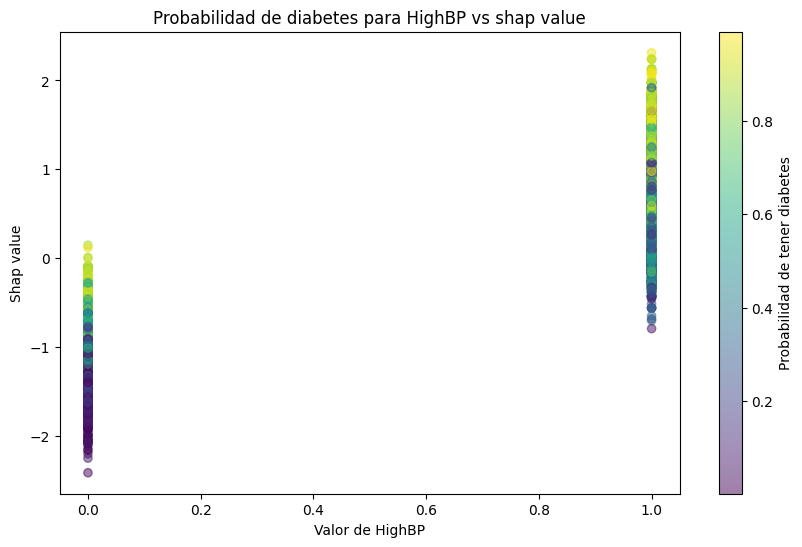

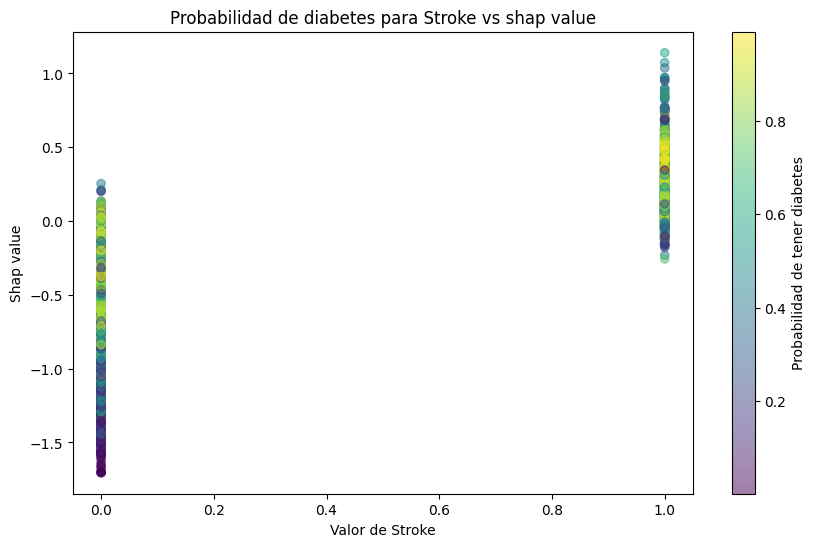

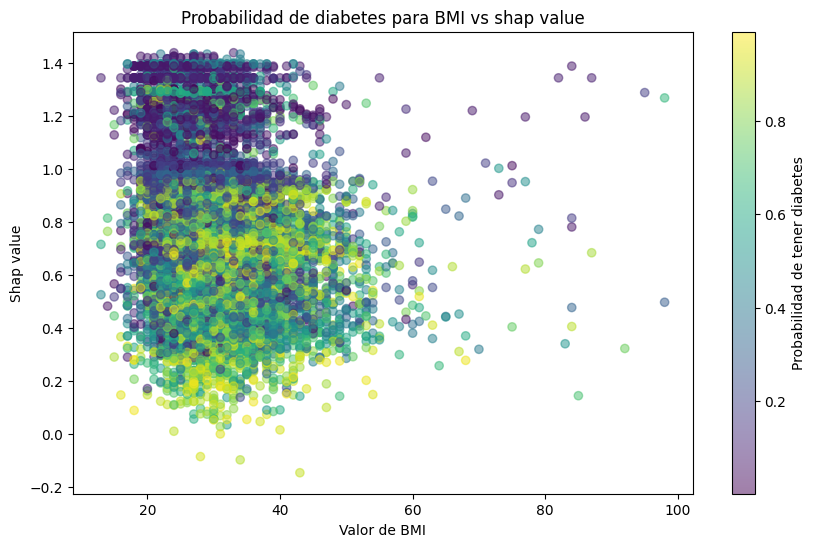

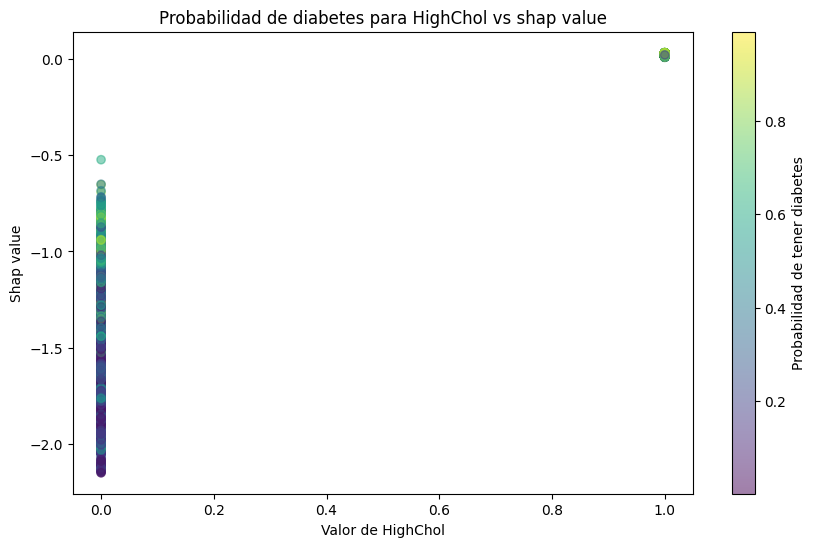

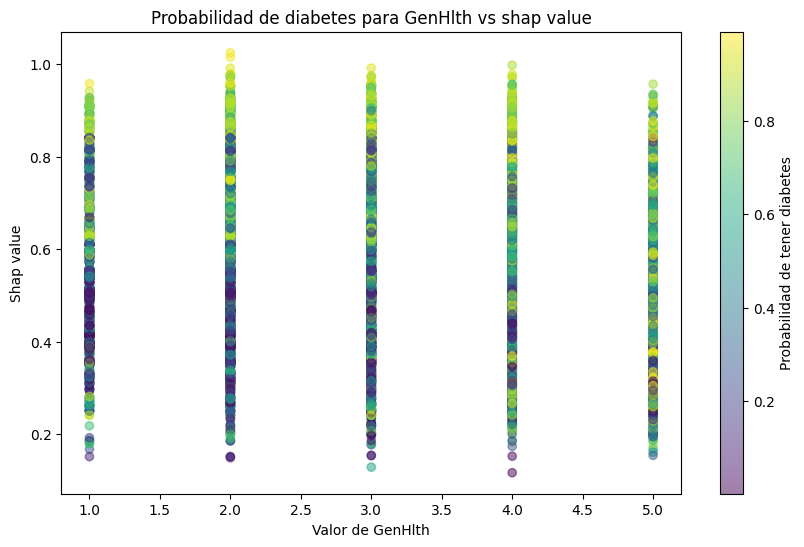

In [26]:
#Calculamos el impacto global de cada feature
summary_vals = np.abs(shap_values).mean(axis=0)

#Tomamos las 5 con mayor impacto
top_features = summary_vals.argsort()[::-1][:5]
probs = model_xgb.predict_proba(X_test)[:, 1]

#Graficamos las 5 features donde el color es la probabilidad de diabetes
for i, feature in enumerate(top_features):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test.iloc[:, feature], shap_values[:, feature], c=probs, alpha=0.5)
    plt.xlabel(f'Valor de {X_test.columns[feature]}')
    plt.ylabel('Shap value')
    plt.title(f'Probabilidad de diabetes para {X_test.columns[feature]} vs shap value')
    plt.colorbar( label='Probabilidad de tener diabetes')
    plt.show()

¿Qué puede concluir de sus resultados?

**Respuesta:**
```
De acuerdo a lo anterior se pueden extraer conclusiones para cada uno de los gráficos.
En el caso de HighBP, se puede ver cómo la probabilidad de padecer diabetes aumenta en conjunto con el shap value.

Para Stroke se ve que la probabilidad aumenta cuando el shap value se encuentra más cercano al rango [0, 0.5] tanto para personas
que hayan o no tenido un infarto.

En el caso de BMI se ve una tendencia a aumentar la probabilidad de diabetes en los shap values más bajos.

En HighChol se puede ver cómo los puntos ubicados en el valor de colesterol alto tienen una mayor probabilidad de tener diabetes
que aquellos que no tienen esta condición.

GenHlth muestra un aumento en la probabilidad de diabetes para los shap values más altos, aunque el valor de GenHlth 5 muestra
una tendencia a probabilidades más altas que los otros.
```

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

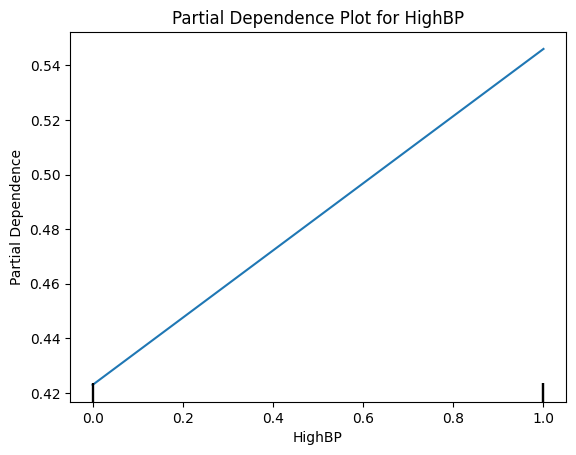

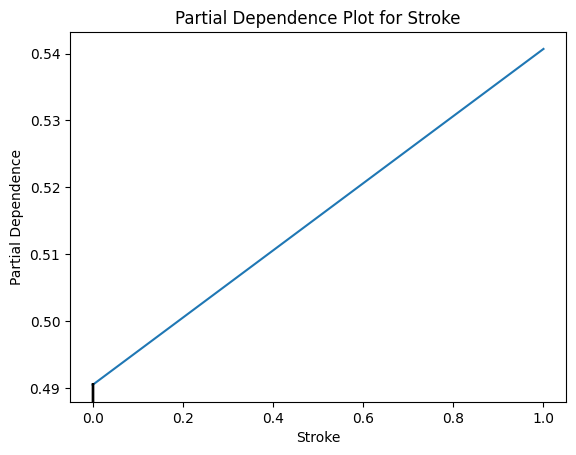

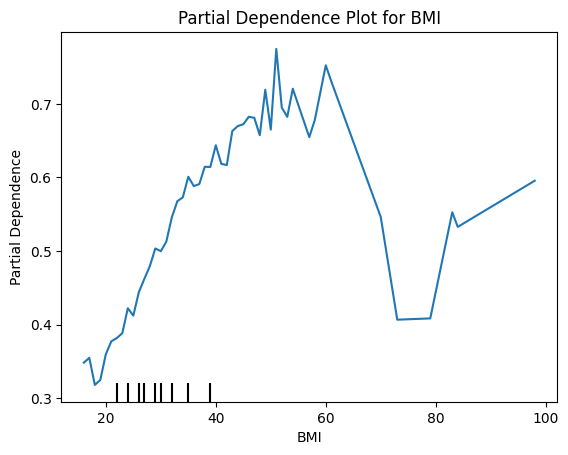

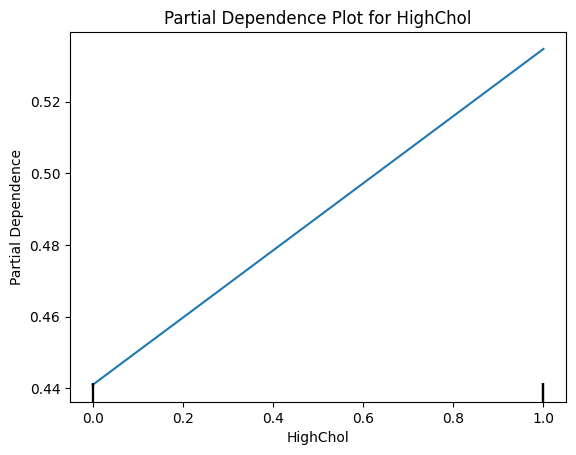

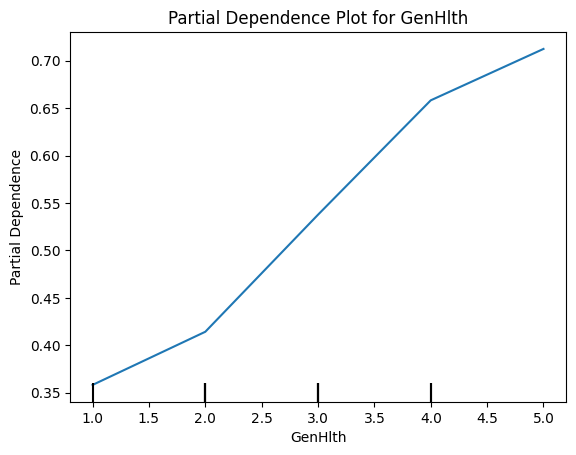

In [23]:
#Creamos un subconjunto de 1000 observaciones
X_subsample = X_test.sample(n=1000, random_state=42)

#Generamos los gráficos Partial Dependence Plot para cada feature
for feature in top_features:
    pd_plot = PartialDependenceDisplay.from_estimator(pipeline, X_subsample, [feature])
    pd_plot.plot(ax=plt.gca())
    plt.xlabel(X_test.columns[feature])
    plt.ylabel('Partial Dependence')
    plt.title(f'Partial Dependence Plot for {X_test.columns[feature]}')
    plt.show()

¿Qué relación existe entre la salida promedio del modelo y cada feature analizada?

**Respuesta:**
```
Para HighBP se ve una relación positiva, donde una alta presión sanguínea lleva a un aumento en la probabilidad de diabetes.
Resultados similares se obtienen para Stroke y HighChol, mientras que en GenHlth se tiene un resultado similar pero no igual,
obteniéndose tres rectas de distintas pendientes, lo que indica que la probabilidad de diabetes aumenta en mayor medida entre los
valores de 2 y 4 en esta variable, aumentando en una tasa menor antes y después de este rango.
El caso más interesante es el de BMI, ya que su gráfico muestra un aumento en la probabilidad de diabetes pero cerca de un BMI de 50
esta probabilidad empieza a fluctuar, teniendo una caída abrupta cerca del valor 60, volviendo a subir posteriormente. Esto puede
deberse a que no exista un gran número de registros con valores tan altos de BMI, de este modo el modelo se ajusta a lo poco que
hay, ya que no es común encontrar personas de 200 o más kilos de peso que es lo necesario para alcanzar BMIs de esta magnitud.
```
¿Son estas conclusiones generalizables para todo el conjunto de datos?

**Respuesta:**
```
Podría decirse que estas conclusiones son generalizables a todo el conjunto de datos, ya que capturan el comportamiento del modelo
para el rango completo de valores de cada característica, mostrando como afecta cada valor a la probabilidad de padecer diabetes. Sin
embargo es importante recordar que esto se obtuvo para una muestra aleatoria pequeña de valores, por lo que dependiendo de lo que se
haya seleccionado en la muestra los resultados podrían estar sesgados.
```

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [24]:
#Creamos el explainer
explainer = AnchorTabular(model_xgb.predict, feature_names=X_test.columns, seed=42)

#Entrenamos el trainer
explainer.fit(X_train.to_numpy())

#Definimos las clases
clases = ['Sin Diabetes', 'Con Diabetes']

#Explicamos la predicción para la observación número 1000
idx = 1000
print(f'Predicción observación: {idx}')
explanation_1000 = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Precision: %.2f' % explanation_1000.precision)
print('Cobertura: %.2f' % explanation_1000.coverage)
print('----Reglas:----')
for rule in explanation_1000.raw['names']:
    print(rule)
print()

#Explicamos la predicción para la observación número 3001
idx = 3001
print(f'Predicción observación: {idx}')
explanation_3001 = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Precision: %.2f' % explanation_3001.precision)
print('Cobertura: %.2f' % explanation_3001.coverage)
print('----Reglas:----')
for rule in explanation_3001.raw['names']:
    print(rule)
print()

#Explicamos la predicción para la observación número 5751
idx = 5751
print(f'Predicción observación: {idx}')
explanation_5751 = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Precision: %.2f' % explanation_5751.precision)
print('Cobertura: %.2f' % explanation_5751.coverage)
print('----Reglas:----')
for rule in explanation_5751.raw['names']:
    print(rule)
print()

Predicción observación: 1000
Precision: 0.97
Cobertura: 0.17
----Reglas:----
HighChol > 0.00
HighBP > 0.00
PhysHlth <= 0.00

Predicción observación: 3001
Precision: 0.97
Cobertura: 0.03
----Reglas:----
Sex > 0.00
HighBP > 0.00
MentHlth > 0.00
Fruits <= 0.00
HvyAlcoholConsump <= 0.00

Predicción observación: 5751
Precision: 0.95
Cobertura: 0.03
----Reglas:----
HighChol > 0.00
Sex > 0.00
PhysHlth <= 0.00
PhysActivity > 0.00
HvyAlcoholConsump <= 0.00
7.00 < Age <= 11.00
GenHlth <= 3.00
MentHlth <= 0.00
Smoker > 0.00



Con las reglas propuestas señale a cuánta población es posible explicar con estas reglas e indique la precisión que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

**Respuesta:**
```
La cobertura de las reglas indica que estas explican a una porción pequeña de la población cercana al 17% de esta para la primera
regla y a un 3% para la segunda y tercera.
Por otra parte las precisiones de las reglas van del 95 al 97%, esto sugiere que las reglas propuestas tienen un buen desempeño
en la identificación de casos positivos.

Las reglas propuestas tienen sentido de acuerdo a las relaciones vistas anteriormente entre los valores de ciertas variables y
la probabilidad de padecer diabetes. Sin embargo estas pueden ser muy simplistas, generalizando mucho los resultados para un
número de características bajo, esto deja en evidencia que es relevante analizar la totalidad de características para cada
individuo a modo de poder observar la combinación completa de features de este, ya que si bien una característica en específico
puede contribuir a aumentar el riesgo de diabetes, no es suficiente para determinar la presencia de esta enfermedad por sí sola.

Aunque las reglas propuestas no se aplican a un porcentaje significativo del conjunto de datos (17%, 3% y 3%,
respectivamente), tienen relevancia en una variedad considerable de situaciones, ya que a pesar de su limitada cobertura, la alta
precisión en los segmentos de la población a los que representan, las hacen útiles y confiables para la interpretación del modelo en
dicho contexto en particular.
```

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

>La interpretación de modelos se aborda desde diversas perspectivas, cada una con sus propios puntos fuertes y limitaciones. La Importancia de las Características proporciona una visión global, destacando las características más relevantes en el conjunto del modelo, aunque no revela cómo cada una afecta a predicciones individuales. Por otro lado, el método SHAP (SHapley Additive exPlanations) ofrece tanto una perspectiva local como global. A nivel local, brinda explicaciones detalladas sobre cómo cada característica contribuye a la predicción para instancias individuales, siendo valioso para entender el razonamiento del modelo en casos específicos. A nivel global, ofrece una visión general de cómo las características impactan las predicciones en conjunto. Los gráficos de dependencia de SHAP y las representaciones de importancia de características ofrecen una visión completa de las decisiones del modelo.

>Las Anchor Rules constituyen un enfoque local que proporciona reglas claras y fácilmente interpretables para explicar por qué el modelo realizó una predicción específica. Este método resulta particularmente útil al ofrecer explicaciones simples y comprensibles, especialmente para personas no expertas en el modelo, como podría ser el caso de pacientes.

>Por otro lado, los Gráficos de Dependencia Parcial (PDP) ofrecen una perspectiva más global, permitiendo comprender cómo los diferentes niveles de una característica impactan la salida promedio del modelo. En la tarea específica de clasificación de la diabetes, tanto SHAP como las Reglas de Anclaje proveen conclusiones detalladas y valiosas. SHAP proporciona una visión detallada de cómo las características afectan las predicciones tanto a nivel individual como general, mientras que las Reglas de Anclaje ofrecen explicaciones claras y comprensibles para predicciones individuales. La elección entre estos métodos dependerá de la necesidad de detalles específicos o de explicaciones más accesibles para audiencias no especializadas.

>Finalmente el método más útil para el doctor Simi depende de si busca establecer patrones generales para el comportamiento de la diabetes en un grupo de personas o si busca explicar los motivos de la presencia de un diagnóstico positivo en un individuo. En el primer caso un método agnóstico global sería lo indicado, mientras que para un individuo lo ideal sería un método agnóstico local.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>